# CS 237:  Homework 12: Discrete-Event Simulation of Queueing System

### Due date: PDF file due Wednesday December 11th@ 11:59PM in GradeScope

#### Homeworks may be handed in late up to noon Sunday 12/15 with no penalty.  There will be possible questions on the final exam about this homework, as well as the previous one. 

Please complete this notebook by filling in solutions where indicated. Be sure to "Run All" from the Cell menu before submitting. 

You may use ordinary ASCII text to write your solutions, or (preferably) Latex. A nice introduction to Latex in Jupyter notebooks may be found here: http://data-blog.udacity.com/posts/2016/10/latex-primer/

As with previous homeworks, just upload a PDF file of this notebook. Instructions for converting to PDF may be found on the class web page right under the link for homework 1. 

## General Instructions

In this homework we will simulate a simple system consisting of a single queue and a single server: 

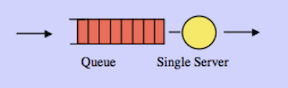

Although this is a very broad idea, we will focus on simulating a ready queue which holds tasks waiting for the CPU. 

How should we approach this simulation? Previously, we did almost all of our simulations using discrete time steps:

<pre>
      for k in range(num_trials):     # you can think of this as one trial every time step k
            ....
</pre>
However, it is very unrealistic to model queues using such a technique, since most queues
exist in an environment when tasks are independent, asynchronous, and arrive at a random time which
is best modeled as a real number, not an integer. We will assume a Poisson arrival process, so we can model the inter-arrival time using an exponential distribution. 


It is also the case that the service time (the amount of
time the task will take in the CPU) will be modeled as a real number, and in fact, experiments show that 
the exponential distribution is also a good model for the service times. 

But now, because we can no longer use a <code>for</code> loop to model time in our simulation, we will have to use a very different approach, which we describe in the rest of this section. 
   


### Discrete-Event Simulation 



 As an overview, I can not do better than the beginning of the Wikipedia article:

<blockquote>
"In the field of simulation, a discrete-event simulation (DES) models the operation of a system as a discrete sequence of events in time. Each event occurs at a particular instant in time and marks a change of state in the system. Between consecutive events, no change in the system is assumed to occur; thus the simulation can directly jump in time from one event to the next.

This contrasts with continuous simulation in which the simulation continuously tracks the system dynamics over time. Instead of being event-based, this is called an activity-based simulation; time is broken up into small time slices and the system state is updated according to the set of activities happening in the time slice. Because discrete-event simulations do not have to simulate every time slice, they can typically run much faster than the corresponding continuous simulation.

Another alternative to event-based simulation is process-based simulation. In this approach, each activity in a system corresponds to a separate process, where a process is typically simulated by a thread in the simulation program. In this case, the discrete events, which are generated by threads, would cause other threads to sleep, wake, and update the system state."
</blockquote>

The essential components of a DES are the following:

<strong>Clock:</strong> A variable keeping track of the current time in seconds (a float). This most important thing to understand about the clock is that it is not like the counter in a for loop, counting off the seconds; rather, the main loop performs one event per iteration, and the clock keeps track of the time elapsed, skipping ahead from one event time stamp to the next. In general, the time interval between events will not be constant.

<strong>Events List:</strong> This is an ordered list of events, each with a code telling what is the kind of action to take, and a time stamp for when the event is to occur, and any other information needed for the event. At each iteration of the main loop, the next event will be removed and the action taken. The usual data structure for this list is a priority queue implemented as a min-heap. 

### State Transitions in the DES

The simulation will go through various changes in configuration or <b>state transitions</b> during execution. In some DES's, the number of states is so large, you would literally write the code with a big loop to determine what state the simulation will go to next. For us, there are really only 3 states, and the simulation code doesn't strictly adhere to this diagram; however, it may be useful for understanding what is happening:

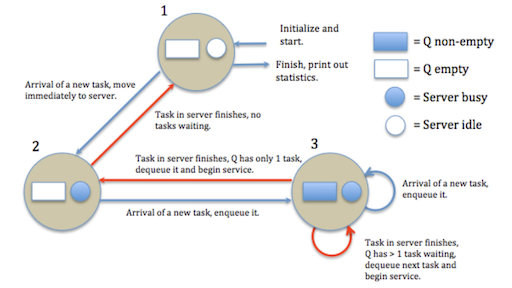

### Data Structures for the DES

An <b>event</b> will be represented by a triple 

            (event_time, event_type, task)

The event_type is an integer code with the following meanings:

  - 0 = arrival event, a task arrives in the queue:                (0, arrival_time, task )
  - 1 = finish event, a task 
  
### Data Structures for the DES

An <b>event</b> will be represented by a triple 

            (event_time, event_type, task)

The event_type is an integer code with the following meanings:

  - 0 = arrival event, a task arrives in the queue:                (0, arrival_time, <task> )
  - 1 = finish event, a task finishes service and leaves the CPU    (1, finish time, <task> )



<b>Tasks</b> are represented by a list
 
            [ arrival_time, service_time, queue_wait_time ], 
            
The queue wait time will be initialized to 0, and updated when a task leaves the queue and starts service. 
       
The <b> events list</b> will be implemented by a heap, using the Python heapq library (see <a href="https://docs.python.org/2/library/heapq.html">this</a> link for details, including examples of how to use it on tuples); the two functions used are:

       heapq.heappush(heap, item)  #Push the value item onto the heap (just a list), maintaining the heap ordering.
       
       heapq.heappop(heap)   # Pop and return the smallest item from the heap, maintaining the heap ordering.
                             # If the heap is empty, IndexError is raised. To access the smallest 
                             # item without popping it, use heap[0].

The <b> Task Queue </b> will also use a heap, ordered in two different ways:

   - FIFO (First-In-First-Out, "First come first served"): The default and simplest implementation; the heap is ordered by arrival time; 
   - SJF (Shortest-Job-First): An implementation which often increases throughput; the heap is ordered by service time, shortest time first.  
 

Other details of the simulation:

 - An initial list of tasks will be generated before the simulation begins, and the simulation will run until all tasks have been processed. 
 - Arrival of tasks will follow a Poisson distribution with rate parameter <code>lam</code> = arrivals per unit time, but expressed by an exponential <code>Exp( lam ) </code> which will give the inter-arrival time; by successively adding the inter-arrival times we arrive at the arrival times (which increase throughout the simulation).
 - The service time of tasks follows a  <b> exponential distribution</b> <code>Exp( beta )</code>, where <code>beta = 1 / (mean service time)</code>;  we can think of <code>beta</code> as the rate at which tasks need the CPU or the rate at which tasks finish and leave the system;  
 - In order to simulate various kinds of loads on the system, it is only necessary to investigate the relationship between <code>lam</code> and <code>beta</code>, in particular when:

<blockquote>
<ul>
 <li> <code>lam</code> $<$ <code>beta</code>:  Tasks finish and depart at a faster rate then they arrive; such a system is <i>under-loaded</i>; 
 <li> <code>lam</code> $=$ <code>beta</code>:  Arrival and departure <i>mean rates</i> are equally matched;    and
 <li> <code>lam</code> $>$ <code>beta</code>:  Tasks arrive faster than they can be served; such a system is <i>over-loaded</i>.   
</ul>
</blockquote>

 - We will be very interested in watching what happens to the system as we change this relationship, as the system goes from underloaded to overloaded; in order to facilitate this, we will keep <code>beta</code> fixed at 0.1 (= mean of 10 tasks finishing per time unit) and vary <code>lam</code> from less than 10, equal to 10, and then beyond.     
 - We will collect various statistics about the simulation and display distributions, see
 the code below. 

            


            
            A pseudo-code version of the algorithm used to run the simulation is as follows:

<pre>

num_tasks = 10**4

current_time = 0

mean_arrival_rate = 100

task_list = []

queue = []

Create an array of <code>num_tasks</code> arrival tasks with exponentially-distributed inter-arrival times and service times; 
     the mean of the service times will be varied (see below).
     Note that the interarrival time need to be added to the last arrival time, to create an increasing sequence
     of time stamps for arrival events.  

while(events list is non-empty) {
    e = get_next_event()
    clock = time stamp of e
    if e is an arrival event
        insert the task into the queue, following the queue discipline being used (FIFO or SJF)
    else # must be a finish event
         if the queue is non-empty
             remove the task at the head of the queue and create a finish event for that task,
                with time stamp and queue wait time as shown in boldface here:
                    
                    ( <b>(current_time + service_time)</b>, 1, [ arrival_time, service_ time, <b>(current_time - arrival_time)</b> ] )
    


Print out the statistics.
          
</pre>



In [1]:
   # Imports potentially used for this lab


import matplotlib.pyplot as plt   # normal plotting

import math
from random import seed, random, uniform, randint
import numpy as np
import scipy.signal           # used to smooth graphs

from collections import Counter

%matplotlib inline

# Calculating permutations and combinations efficiently

def P(N,K):
    res = 1
    for i in range(K):
        res *= N
        N = N - 1
    return res
           
def C(N,K):
    if(K < N/2):
        K = N-K
    X = [1]*(K+1)
    for row in range(1,N-K+1):
        X[row] *= 2
        for col in range(row+1,K+1):
            X[col] = X[col]+X[col-1]
    return X[K]

# Useful code from lab 01

# This function takes a list of outcomes and a list of probabilities and
# draws a chart of the probability distribution.

def draw_distribution(Rx, fx, title='Probability Distribution for X'):
    plt.figure(figsize=(8, 4))
    plt.bar(Rx,fx,width=1.0,edgecolor='black')
    plt.ylabel("Probability")
    plt.xlabel("Outcomes")
    if (Rx[-1] - Rx[0] < 30):
        ticks = range(Rx[0],Rx[-1]+1)
        plt.xticks(ticks, ticks)     
    plt.title(title)
    plt.show()
    
# This function takes a list of outcomes, calculates a histogram, and
# then draws the empirical frequency distribution.

def show_distribution(outcomes, title='Empirical Probability Distribution'):
    num_trials = len(outcomes)
    Rx = range( int(min(outcomes)), int(max(outcomes))+1 )
    freqs = Counter(outcomes)
    fx = [freqs[i]/num_trials for i in Rx]
    draw_distribution(Rx, fx, title=title)

def round4(x):
    return round(x+0.00000000001,4)

def round4_list(L):
    return [ round4(x) for x in L]


In [2]:
# Two kinds of queues

import heapq

arrival_event = 0
finish_event = 1

def task_to_string(task):
    return str([task[0], round4(task[1]),round4(task[2])])

class FIFO_Queue:
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []

    def enqueue(self, item):
        self.items.insert(0,item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)
    
    def show(self):
        if self.isEmpty():
            return "empty\n"
        ret = ""
        for k in range(len(self.items)-1,-1,-1):
            ret += "\n\t" + task_to_string(self.items[k])
        return  ret+"\n" 
    
class SJF_Queue:
    def __init__(self):
        self.heap = []

    def isEmpty(self):
        return self.heap == []

    def enqueue(self, item):
        # wrap the task in a tuple so can be heap ordered
        tup = (item[1],item)
        heapq.heappush(self.heap, tup)

    def dequeue(self):
        return heapq.heappop(self.heap)[1]

    def size(self):
        return len(self.heap)
    
    def show(self):
        if self.isEmpty():
            return "empty\n"
        ret = ""
        for k in range(len(self.heap)):
            ret += "\n\t" + task_to_string(self.heap[k][1])
        return ret+"\n" 


def event_to_string(event):
    if event[1] == arrival_event:      
        return "( " + str(round4(event[0])) + ", arrival, " + task_to_string(event[2]) + " )"
    else:     
        return "( " + str(round4(event[0])) + ", finish, " + task_to_string(event[2]) + " )"
    
class Event_Queue:
    def __init__(self):
        self.heap = []

    def isEmpty(self):
        return self.heap == []

    def enqueue(self, item):
        heapq.heappush(self.heap, item)

    def dequeue(self):
        return heapq.heappop(self.heap)

    def size(self):
        return len(self.heap)
    
    def show(self):
        if self.isEmpty():
            return "empty\n"
        ret = ""
        for k in range(len(self.heap)):
            ret += "\n\t" + event_to_string(self.heap[k])
        return ret+"\n"  

In [3]:
# Testing the queues

print("\nNote: printouts of queues and heaps are with head or min value at top;")
print("remember that heaps are not in decreasing order but heap ordered.\n")

print("FIFO")
Q = FIFO_Queue()
Q.enqueue([0,.5,.4,0])
Q.enqueue([1,.1,.2,0])
Q.enqueue([2,.2,.3,0])

print(Q.size())
print(Q.isEmpty())
print(Q.show())
print(Q.dequeue())
print(Q.dequeue())
print(Q.size())
print(Q.isEmpty())
print()

print("SJF")
Q2 = SJF_Queue()
Q2.enqueue([0,.5,.4,0])
Q2.enqueue([1,.1,.2,0])
Q2.enqueue([2,.2,.3,0])
print(Q2.size())
print(Q2.isEmpty())
print(Q2.show())
print(Q2.dequeue())
print(Q2.dequeue())
print(Q2.size())
print(Q2.isEmpty())
print()

print("Event")
H = Event_Queue()
H.enqueue((61,0,[0,61,3,4]))
H.enqueue((9,1,[1,9,3,4]))
H.enqueue((1,0,[2,1,3,4]))
H.enqueue((19,0,[3,19,3,4]))
H.enqueue((0,0,[4,0,3,4]))
H.enqueue((99,0,[5,99,3,4]))
print(H.size())
print(H.isEmpty())
print(H.show())
while( not H.isEmpty()):
    print(event_to_string(H.dequeue()))

print(H.size())
print(H.isEmpty())
print(H.show())


Note: printouts of queues and heaps are with head or min value at top;
remember that heaps are not in decreasing order but heap ordered.

FIFO
3
False

	[0, 0.5, 0.4]
	[1, 0.1, 0.2]
	[2, 0.2, 0.3]

[0, 0.5, 0.4, 0]
[1, 0.1, 0.2, 0]
1
False

SJF
3
False

	[1, 0.1, 0.2]
	[0, 0.5, 0.4]
	[2, 0.2, 0.3]

[1, 0.1, 0.2, 0]
[2, 0.2, 0.3, 0]
1
False

Event
6
False

	( 0.0, arrival, [4, 0.0, 3.0] )
	( 1.0, arrival, [2, 1.0, 3.0] )
	( 9.0, finish, [1, 9.0, 3.0] )
	( 61.0, arrival, [0, 61.0, 3.0] )
	( 19.0, arrival, [3, 19.0, 3.0] )
	( 99.0, arrival, [5, 99.0, 3.0] )

( 0.0, arrival, [4, 0.0, 3.0] )
( 1.0, arrival, [2, 1.0, 3.0] )
( 9.0, finish, [1, 9.0, 3.0] )
( 19.0, arrival, [3, 19.0, 3.0] )
( 61.0, arrival, [0, 61.0, 3.0] )
( 99.0, arrival, [5, 99.0, 3.0] )
0
True
empty



In [4]:
# codes for event types

arrival_event = 0
finish_event = 1

def run(tasks, queue_discipline, trace=False):

    clock = 0    # current time in the simulation
    
    if queue_discipline == "FIFO":
        task_queue = FIFO_Queue()
    else:
        #print("using SJF")
        task_queue = SJF_Queue() 
    
    event_list = Event_Queue()
    
    for k in range(len(tasks)):
        event_list.enqueue( (tasks[k][0],arrival_event,tasks[k] ) )
        
    finished_tasks = FIFO_Queue()
    
    CPU = []        # empty list indicates CPU is idle
    
    if trace:
        print("\nExecution Trace")
        print("\nNote: printouts of queues and heaps are with head or min value at top;")
        print("remember that heaps are not in decreasing order but heap ordered.\n")
    
    while(not (event_list.isEmpty())):
        
        if trace:
            print("\n==============================================================")
            print("\nClock: " + str(round4(clock)))
            print("\nEvents: " + event_list.show())
            print("Task queue: " + str(task_queue.show()))
            if CPU != []:
                print("CPU processing task " + task_to_string(CPU))
            else:
                print("CPU idle")
            
            print("\nFinished tasks: " + str(finished_tasks.show()))
        
        # get the next event
        next_event = event_list.dequeue()
        
        if trace:
            print("--------------------------------------------------------------")
            
        if trace:
            print("\nNext Event: \n\t" + event_to_string(next_event))
        
        # update the clock to this event's time
        clock = next_event[0]
        
        # arrival event
        if next_event[1] == arrival_event:
            if CPU == []:                # Q and CPU both empty, no wait, insert finish event
                if trace:
                    print("\nCPU and task queue both empty, task goes directly to CPU, create finish event.")
                task = next_event[2]
                arrival_time = task[0]
                service_time = task[1]
                task[2] = clock - arrival_time            # queue_wait_time
                finish_time = clock + service_time
                event_list.enqueue(  ( finish_time, finish_event, task )   )
                CPU = task
            else:
                task_queue.enqueue(next_event[2])
                if trace:
                    print("\nCPU busy, insert arriving task in task queue.")
                 
        # finish event, so put task in list of finished tasks and get next task from queue if exists
        else:
            finished_tasks.enqueue(next_event[2])
            if trace:
                print("\nTask in CPU finishes.")
            CPU = []
            if not task_queue.isEmpty():  
                if trace:
                    print("\nDequeue next task and start to run in CPU, create finish event.")
                task = task_queue.dequeue()
                arrival_time = task[0]
                service_time = task[1]
                task[2] = clock - arrival_time            # queue_wait_time
                finish_time = clock + service_time
                event_list.enqueue(  ( finish_time, finish_event, task )   )
                CPU = task
            elif trace:
                    print("\nTask queue empty, CPU becomes idle.")
    if trace:
        print("\nAll tasks complete, simulation ends.") 
        print("\nFinished tasks: " + str(finished_tasks.show()))
        print("==============================================================\n")
    
    tasks = []
    while not finished_tasks.isEmpty():
        tasks.append(finished_tasks.dequeue())
        
    return tasks                 


In [5]:
# this prints out GANNT charts and charts for CPU
# utilization, queue length, and queue length distribution. 

def analyzeResults(task,showCharts=True,showStats=True):  
        
    # Determine various parameters and means
    
    numTasks = len(task)
    
    totalTime = task[-1][0]+task[-1][1]+task[-1][2]
    
    meanServiceTime = np.mean([task[k][1] for k in range(len(task))])
    
    meanInterarrivalTime =  task[-1][0] / len(task)
        
    meanWaitTime = np.mean([task[k][2] for k in range(len(task))])
        
    cpuUtilization = sum( [ task[k][1] for k in range(len(task))]) / totalTime
    
    increment = 0.001                       # use to create charts and collect stats

    X = np.arange(0,totalTime,increment)
           
    if showCharts:
        
        # Print GANTT Chart

        fig = plt.figure(figsize=(15,10))
        fig.subplots_adjust(hspace=.5)
        ax1 = fig.add_subplot(311)       
        #plt.yticks(range(len(task)))    
        plt.ylim((-0.5,len(task)))
        plt.title('GANNT Chart')
        plt.ylabel('Task Number')
        plt.xlabel('Time (sec)')   

        if len(task) > 50:
            lw = 1
        elif len(task) > 20:
            lw = 2
        elif len(task) > 10:
            lw = 3
        else:
            lw = 4

        for k in range(len(task)):
            arrival = task[k][0]
            begin_service = arrival + task[k][2]
            end_service = begin_service + task[k][1]
            plt.hlines(k, arrival, begin_service, color='C0',linestyle='dotted',linewidth=lw)
            plt.hlines(k, begin_service, end_service, color='C0',linestyle='solid',linewidth=lw) 

        # Print CPU Utilization Chart
        
        Y = np.zeros(len(X))

        for k in range(len(task)):
            arrival = task[k][0] 
            begin_service = arrival + task[k][2] 
            end_service = begin_service + task[k][1] 
            for x in np.arange(begin_service,end_service,increment):
                Y[int(x/increment)] = 1

        Y = scipy.signal.medfilt(Y)
        Y[-1] = 0 

        fig.add_subplot(312,sharex=ax1)
        #plt.yticks(range(len(task)))    
        plt.title('CPU Utilization')    
        plt.ylabel('Usage')
        plt.xlabel('Time (sec)')    
        plt.ylim((-0.15,1.2))  
        plt.plot(X,Y)
    
    # Plot Queue length over time
    
    Y1 = np.zeros(len(X))
      
    for k in range(len(task)):
        arrival = task[k][0]
        begin_service = arrival + task[k][2]
        for x in np.arange(arrival,begin_service,increment):
            Y1[int(x/increment)] += 1
    
    Y1 = scipy.signal.medfilt(Y1)
    
    Y1[-1] = 0 
    
    if showCharts:
        
        maxLength = int(max(Y1))

        fig.add_subplot(313,sharex=ax1)
        #plt.yticks(range(maxLength+1))    
        plt.title('Queue Length Over Time')    
        plt.ylabel('Queue Length')
        plt.xlabel('Time (sec)')    
        plt.ylim((-0.5,maxLength+ 0.5))
        plt.plot(X,Y1)
        plt.show()
        
        show_distribution(Y1,title="Distribution of Queue Lengths")

        
    maxQueueLength = max(Y1)
    meanQueueLength = np.mean(Y1)
    stdQueueLength = np.std(Y1)

    
    if showStats:
        print("\nNumber of Tasks:\t" + str(numTasks)) 
        print("Total Time:\t\t" + str(round4(totalTime)))
        print("Mean Interarrival Time:\t" + str(round4(meanInterarrivalTime)))
        print("Mean Wait Time:\t\t" + str(round4(meanWaitTime)))
        print("Mean Service Time:\t" + str(round4(meanServiceTime)))
        print("CPU Utilization:\t" + str(round4(cpuUtilization)))
        print("Maximum queue length:\t" + str(round4(maxQueueLength)))
        print("Mean queue length:\t" + str(round4(meanQueueLength)))
        print("Std of queue length:\t" + str(round4(stdQueueLength)))
    
    return [numTasks,totalTime,meanInterarrivalTime,meanWaitTime,
            meanServiceTime,cpuUtilization,
            maxQueueLength,meanQueueLength,stdQueueLength]
        

## Problem Zero

Nothing to hand in here, but you need to understand how tasks are represented, and how they proceed through the system before you can do the probability problems to follow. 

Each <b>task</b> is represented by a list
 
            [ arrival_time, service_time, queue_wait_time ],
            
where the list of tasks is given in order of arrival time, and the last parameter is 0 (it will be filled in by
the simulation and the resulting list returned by the simulation). 

Play around with these examples, including changing the parameters to try different queue disciplines (FIFO or Shortest Job First), and exhaustive tracing of the simulation. When you are comfortable with the framework,
continue with the rest of the problems. 

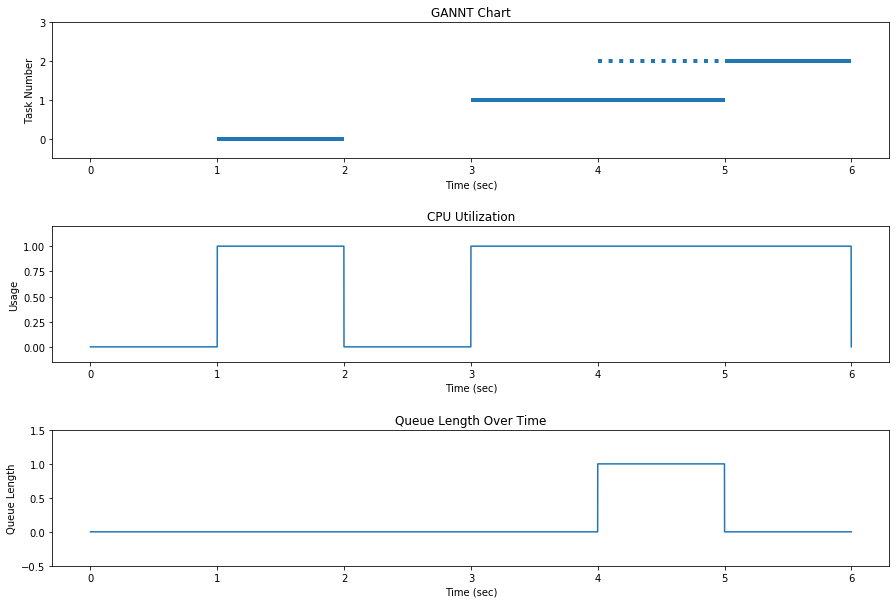

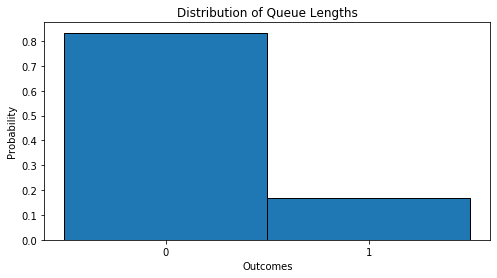


Number of Tasks:	3
Total Time:		6.0
Mean Interarrival Time:	1.3333
Mean Wait Time:		0.3333
Mean Service Time:	1.3333
CPU Utilization:	0.6667
Maximum queue length:	1.0
Mean queue length:	0.1667
Std of queue length:	0.3727


In [6]:
tasklist1 = [[1, 1, 0],           # Basic example 
             [3, 2, 0],           # FIFO vs SJF will not make a difference here
             [4, 1, 0]]

tasklist2 = [[1, 4, 0],           # This example will show the difference between FIFO and SJF
             [2, 5, 0],           # In FIFO, tasks executed as they arrive (tasks 0,1,2,3)
             [3, 2, 0],           # In SJF, tasks will be executed in order 
             [6, 3, 0]]

tasklist3 = [[0.1, 0.1, 0],       # A more complicated example!
             [0.3, 0.4, 0],       # Will also behave differently under FIFO and SJF
             [0.5, 0.2, 0],
             [0.6, 0.3, 0],
             [0.8, 0.2, 0]]

tasklist4 = [[0,2,0], [1.1,3,0], [3.4,4,0], [3.45,3,0], [5,3.23,0],[6.2,2.9,0],[6.4,2.32,0], [9.99,1.2,0], [10.3,3.4,0], [12.8,3.9,0], [15.2,3.4,0],
       [15.67,2.43,0],[17.01,2.8,0],[18.8,2.2,0],[20.1,2.99,0],[21.7,5.34,0],[24.4,2.2,0]]

tasks = tasklist1
#tasks = tasklist2
#tasks = tasklist3
#tasks = tasklist4

# run the simulation with the given task list
# the second parameters gives the queue discipline, either "FIFO" or "SJF"
# the third parameter controls whether an exhaustive trace is done of the simulation

finished = run(tasks,"FIFO",False)
#finished = run(tasks,"SJF",False)           # use shortest job first scheduling
#finished = run(tasks,"FIFO",True)           # exhaustive tracing
#finished = run(tasks,"SJF",True)

#print(finished)

# Analyze the results, printing out various charts, and return relevant statistics

stats = analyzeResults(finished)

# stats = [numTasks,totalTime,meanInterarrivalTime,meanWaitTime,meanServiceTime,
#          cpuUtilization,maxQueueLength,meanQueueLength,stdQueueLength] 

# It took me an hour to run some of these examples, not sure why. Hopefully they would not affect the results much!

## Problem One

(A)  Give a task list <code>ans1</code> which will produce the following Gannt Chart using FIFO:
    
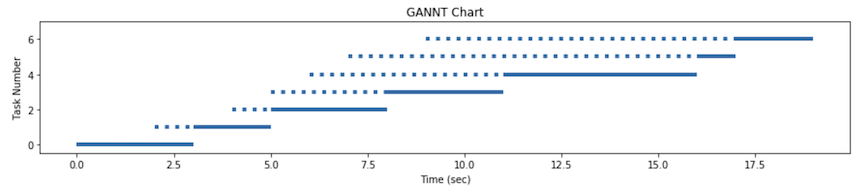

(B)  Give a task list <code>ans2</code> which will produce the following Gannt Chart using SJF:
    
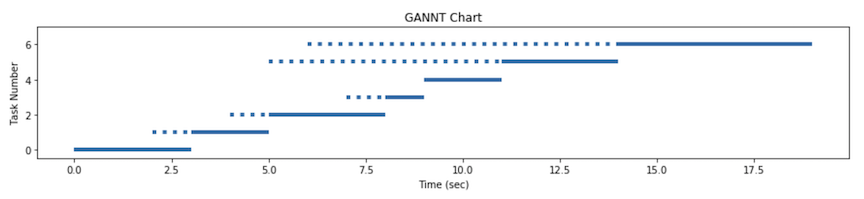

(Hint: All arrival times and service requests will be integers.)



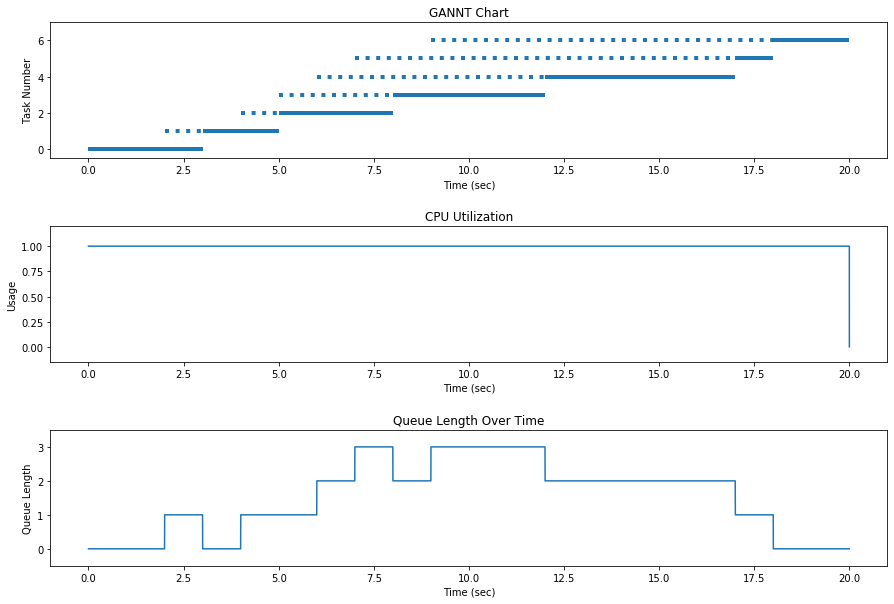

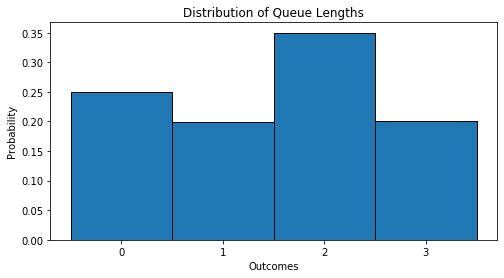


Number of Tasks:	7
Total Time:		20.0
Mean Interarrival Time:	1.2857
Mean Wait Time:		4.2857
Mean Service Time:	2.8571
CPU Utilization:	1.0
Maximum queue length:	3.0
Mean queue length:	1.4999
Std of queue length:	1.0725


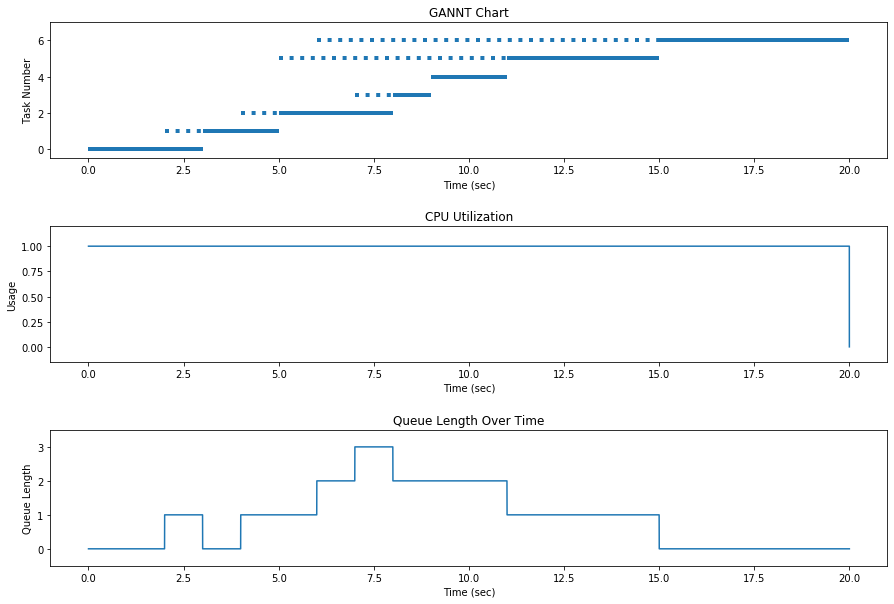

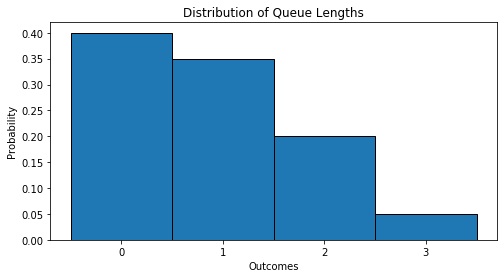


Number of Tasks:	7
Total Time:		20.0
Mean Interarrival Time:	0.8571
Mean Wait Time:		2.5714
Mean Service Time:	2.8571
CPU Utilization:	1.0
Maximum queue length:	3.0
Mean queue length:	0.9
Std of queue length:	0.8888


In [7]:
ans1a = [ [0, 3, 0],                      
         [2, 2, 0],                     
         [4, 3, 0],          
         [5, 4, 0],          
         [6, 5, 0],           
         [7, 1, 0],          
         [9, 2, 0] ]    # your answer here

stats = analyzeResults(run(ans1a,"FIFO",False))

ans1b = [ [0, 3, 0],                      
         [2, 2, 0],                    
         [4, 3, 0],          
         [7, 1 ,0],         
         [9, 2 ,0],        
         [5, 3, 0],         
         [6, 5, 0] ]    # your answer here

stats = analyzeResults(run(ans1a,"SJF",False))



## Problem Two: Generating a Task List

Now we are going to generate a list of tasks following an Exponential Distribution for
both the interarrival time and the service time. This is a very common assumption 
when doing these kind of queueing simulations.  As described above, we will let

  - lam = the mean arrival rate of tasks in the system, and
  - beta = 0.1 = mean service rate requested by tasks
  
but only <code>lam</code> will be changed during the simulation, from below 10 (underload) to above 10 (overload). 

Recall that <b>tasks</b> are represented by a list
 
            [ arrival_time, service_time, queue_wait_time ],

where the last component is initialized to 0, and set during the simulation. From the list of completed tasks, it is possible to generate all the statistics discussed above (this will already be done for you in the code). 

We will use the <code>scipy.stats</code> function <code>expon.rvs(scale)</code>  to generate the random variates for
the interarrival times of tasks, and also for the service times of tasks. 

This Python function uses scale = $\beta$ (the mean of the distribution) as a parameter, so you have to be careful, since it is the exact opposite of the way these distributions are described in the literature: 

   - If you are interested in generating exponential variates with mean <code>beta</code>, then you call <code>expon.rvs(scale=beta)</code>, but 
   - If you are interested in interarrival times of a Poisson process with arrival rate of <code>lam</code> arrivals per unit time, then you would call <code>expon.rvs(scale=1/lam)</code>. 

### Part (A):  

Complete the following to generate a list of tasks to input into the system, and then run the simulation and observe the results. 

Hint: Don't forget that the inter-arrival times have to be added together to get the succession of actual arrival times. 

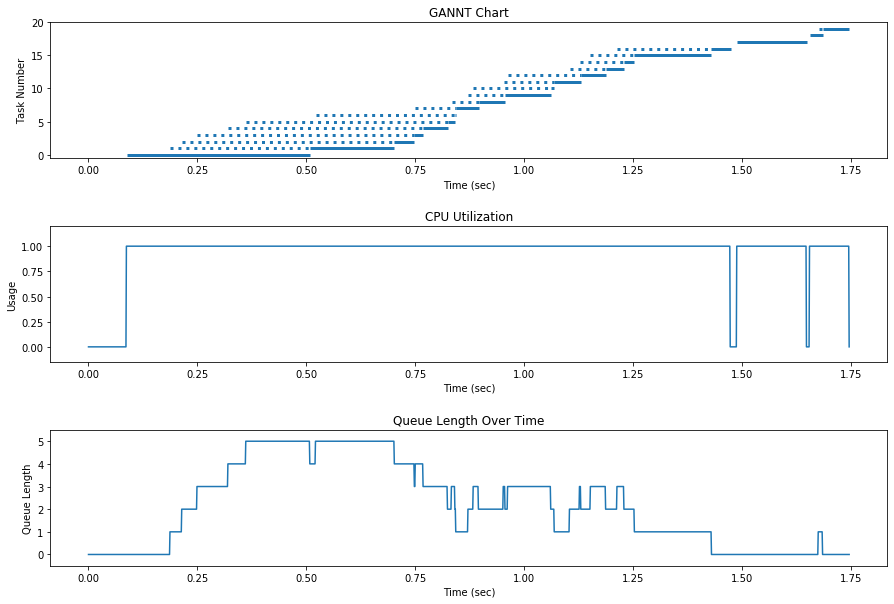

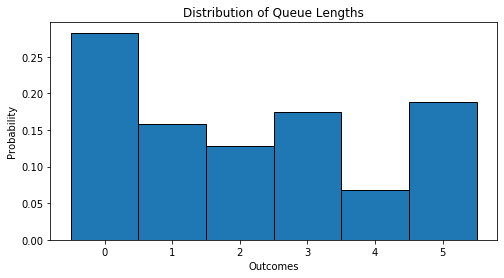


Number of Tasks:	20
Total Time:		1.7466
Mean Interarrival Time:	0.0838
Mean Wait Time:		0.1874
Mean Service Time:	0.0819
CPU Utilization:	0.9373
Maximum queue length:	5.0
Mean queue length:	2.1494
Std of queue length:	1.8446


In [8]:
from scipy.stats import expon

def getTaskList(num_tasks,lam,beta):
    time = 0
    tasks = []
    for i in range(num_tasks):
        time += expon.rvs(scale=1/lam)
        tasks.append([time,expon.rvs(scale=beta),0])
    return tasks

    # Your code here


# parameters for the simulation

num_tasks = 20
lam = 10      # mean arrival rate of tasks in the system -- this is the only parameter we will change
beta = 0.1   # mean service time of arriving tasks -- do not change this parameter

stats = analyzeResults(run(getTaskList(num_tasks,lam,beta),"FIFO",False))

### Part (B)

Run the same simulation, but with the arrival rate set much lower than 10, say at 5. 

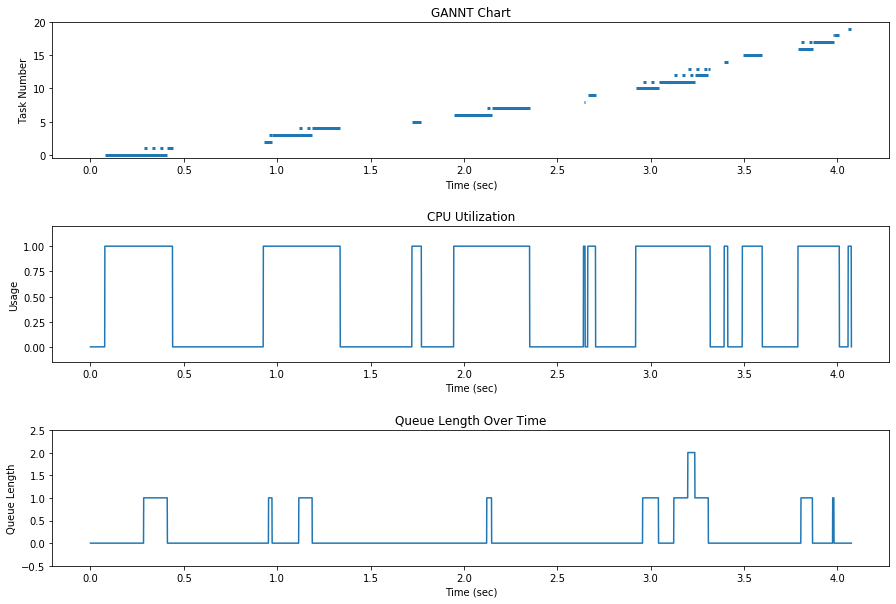

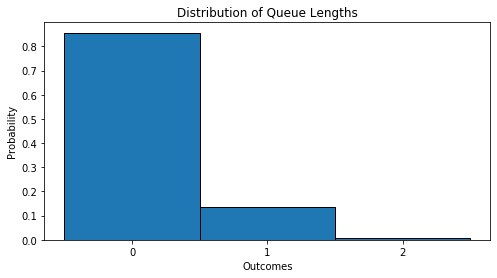


Number of Tasks:	20
Total Time:		4.0761
Mean Interarrival Time:	0.203
Mean Wait Time:		0.0308
Mean Service Time:	0.1021
CPU Utilization:	0.501
Maximum queue length:	2.0
Mean queue length:	0.1523
Std of queue length:	0.3844


In [9]:
lam = 5
stats = analyzeResults(run(getTaskList(num_tasks,lam,beta),"FIFO",False))

### Part (C)

Now run the simulation with <code>lam</code> = 20. 

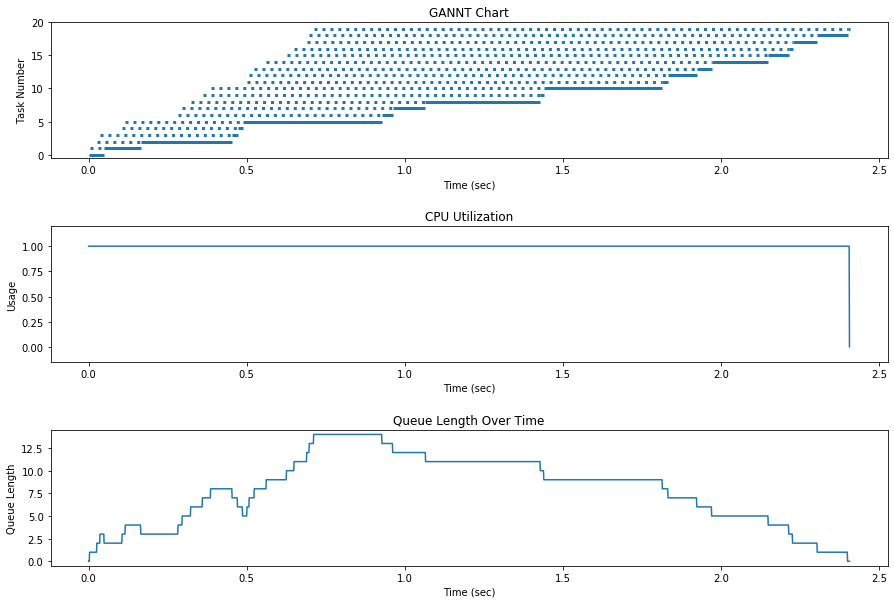

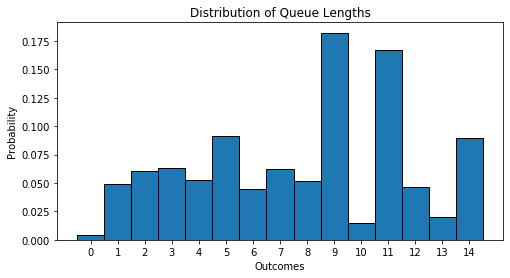


Number of Tasks:	20
Total Time:		2.4072
Mean Interarrival Time:	0.0356
Mean Wait Time:		0.9438
Mean Service Time:	0.1203
CPU Utilization:	0.9998
Maximum queue length:	14.0
Mean queue length:	7.843
Std of queue length:	3.8136


In [10]:
lam = 20
stats = analyzeResults(run(getTaskList(num_tasks,lam,beta),"FIFO",False))

### Part (D)

Now I would like you to also generate the same simulations, but using SJF (no need to give them all, just run them),
and to run these various times to get a feel for how they behave, and then answer the following in a sentence or two:

When the lam = 10, the arrival rate and departure rate are evenly matching, and we might expect that the system could deal with all the requests. But is this case?  Look at your results and answer this question: **"When the rates are evenly matched, do the results look more like the overloaded case or the underloaded case?  Does using FIFO vs SJF change this?"**

(Hint: don't worry about being too precise, I just want you to think about the issue a bit after observing the simulations.)

**Answer:**

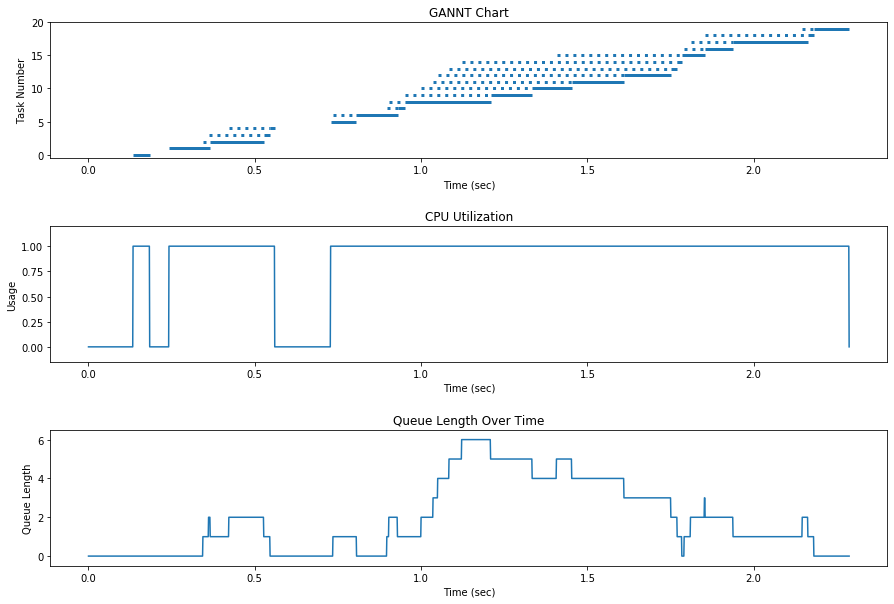

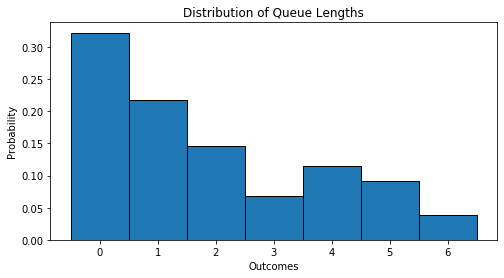


Number of Tasks:	20
Total Time:		2.2878
Mean Interarrival Time:	0.1073
Mean Wait Time:		0.2127
Mean Service Time:	0.0963
CPU Utilization:	0.8421
Maximum queue length:	6.0
Mean queue length:	1.8623
Std of queue length:	1.8574


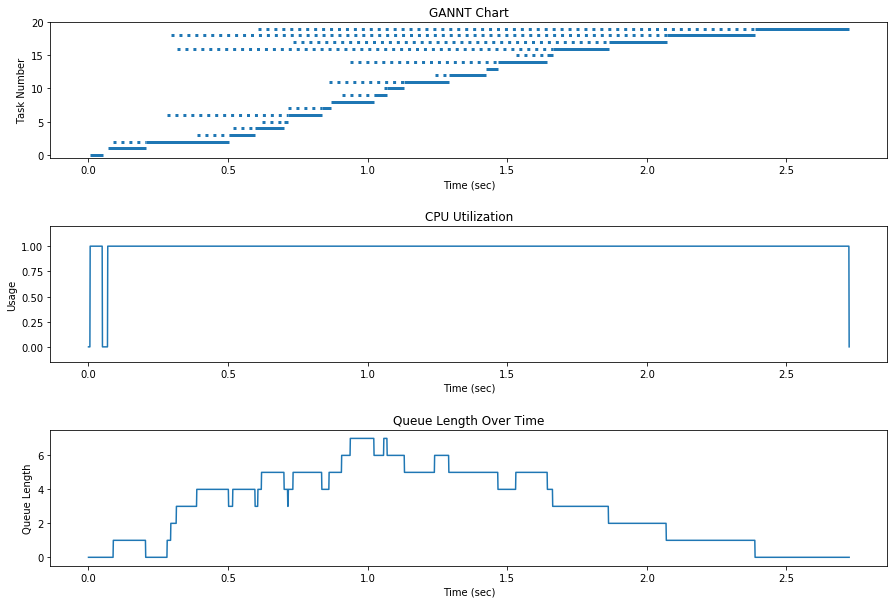

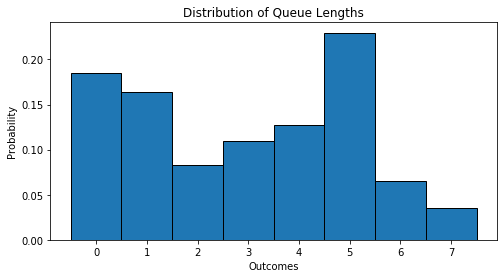


Number of Tasks:	20
Total Time:		2.7259
Mean Interarrival Time:	0.0304
Mean Wait Time:		0.4031
Mean Service Time:	0.135
CPU Utilization:	0.9905
Maximum queue length:	7.0
Mean queue length:	2.9596
Std of queue length:	2.1465


In [11]:
num_tasks = 20
lam = 10
beta = 0.1
stats = analyzeResults(run(getTaskList(num_tasks,lam,beta),"FIFO",False))
stats = analyzeResults(run(getTaskList(num_tasks,lam,beta),"SJF",False))

For this problem I decided to compare FIFO and SJF with same parameters. From the above figures we can guess that FIFO seems to be overloaded while SJF is the opposite. I think it is due to gaps in FIFO compared to SJF. I do not think it matters too much which one we choose, because the relative amout of time that CPU works is very similar.

## Problem Three

Now we are going to run multiple trials of our simulation with different values of lam,
and graph and analyze the results. 
In this problem, we will see the effect of changing <code>lam</code> by graphing three different
result values against <code>lam</code>. 


### Part (A)  

Complete the following code template to graph the CPU Utilization against lam and observe that this
increases to the overload point and then remains close to 1.0. 


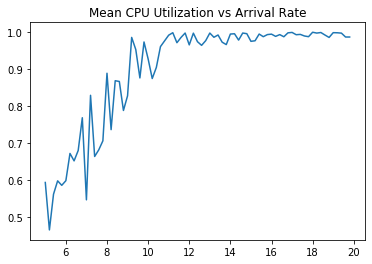

In [22]:
"""  You may find the following useful: 
numTasks = results[0]
totalTime = results[1]
meanInterarrivalTime = results[2]
meanWaitTime = results[3]            
meanServiceTime = results[4]
cpuUtilization = results[5]         
maxQueueLength = results[6]         
meanQueueLength = results[7]          
stdQueueLength = results[8]
"""
        
# Plot the statistic at results[numStat] against the sequence of lam values in lams
# schedule is "FIFO" or "SJF" and titl is for the plot

def plotStat(numStat,numTasks,lams,beta,schedule,titl):
    stat = []     
    result = []     
    for i in range(len(lams)):         
        result = analyzeResults(run(getTaskList(numTasks,lams[i],beta), schedule,False),False,False)         
        stat.append(result[numStat])     
    plt.title(titl)
    plt.plot(lams,stat)
    plt.show()
    
    # for each lam in lams, run the simulation and collect the statistic results[numStat] in a list,
    # then plot these against lams to see the effect of arrival rate on this statistic

    pass
     
numTasks = 200
lams = list(np.arange(5,20,0.2))   # the different values of lam to use in this problem
beta = 0.1                         # mean service time of arriving tasks -- do not change this parameter


plotStat(5,numTasks,lams,beta,schedule="FIFO",titl="Mean CPU Utilization vs Arrival Rate")

### Part (B)

Now plot these parameters vs the arrival rate using FIFO:

  - Mean Wait Time
  - Mean Queue Length
  - Std of Queue Length

and answer the following question:  "How do these behave as they exceed the overload point?  Do changes happen at the overload point or before?"

I am just looking for general observations, nothing too deep, just a couple of sentences of what you observe. 

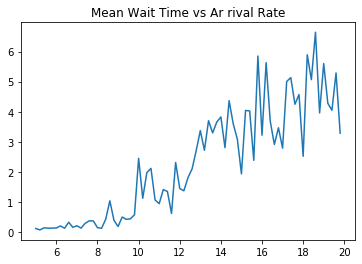

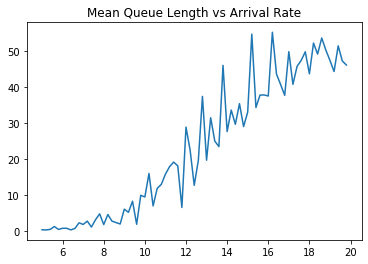

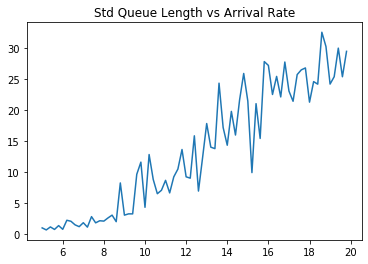

In [13]:
numTasks = 200 
lams = list(np.arange(5,20,0.2))
beta = 0.1

plotStat(3,numTasks,lams,beta,schedule="FIFO",titl="Mean Wait Time vs Ar rival Rate") # orange  (top) 
plotStat(7,numTasks,lams,beta,schedule="FIFO",titl="Mean Queue Length vs Arrival Rate") # blue (bottom) 
plotStat(8,numTasks,lams,beta,schedule="FIFO",titl="Std Queue Length vs Arrival Rate")# green (middle)


**Answer to (B):**

We can see how the flow of graph changes before and after the overload point. Before the point, the graph is steady, however after the point, when the lam is more than 10, the graph grows extremely fast, probably bevause of many jobs awaiting in the queu. The reason for gap between points is because of the length of jobs. I believe if we ran it multiple times, the graph will be steadier.

## Problem Four

Now the question that might occur to you is: "What would happen if we use SJF in the previous problem"? 

Compared with
FIFO,  SJF scheduling provides a shorter mean wait time (meaning, as a whole, jobs spend less time in the system) but may suffer from starvation (long jobs may wait a very long time). 

We will only look at 

   - CPU Utilization
   - Mean Queue Length
   - Std Queue Length

### Part (A)

Repeat the experiment of the previous problem, but using FIFO and SJF and only for the three statistics just given. I would like you to plot FIFO and SJF on the same graph, in order to compare. 

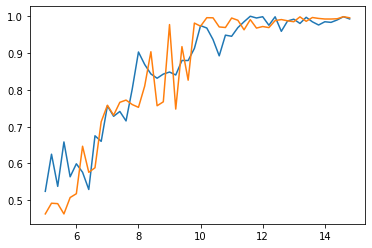

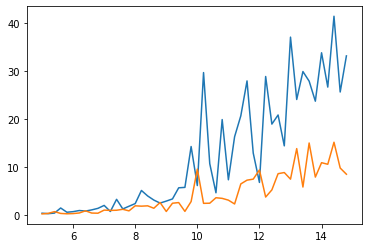

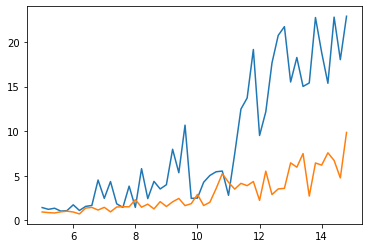

In [32]:
def plotStatistics2(numTasks,lams,beta):

    param = [5,7,8]     
    for j in range(len(param)):         
        sjfStat = []         
        fifoStat = []         
        fifoResults = []         
        sjfResults = []         
        for i in range(len(lams)):             
            fifoResults = analyzeResults(run(getTaskList(numTasks,lams[i ],beta),"FIFO",False),False,False)             
            fifoStat.append(fifoResults[param[j]])             
            sjfResults = analyzeResults(run(getTaskList(numTasks,lams[i ],beta),"SJF",False),False,False)             
            sjfStat.append(sjfResults[param[j]])         
        a = plt.plot(lams,fifoStat)         
        b = plt.plot(lams,sjfStat)         
        plt.show()
    
    # Your code here
        
    
numTasks = 200
lams = list(np.arange(5,15,0.2))   # the different values of lam to use in this problem
beta = 0.1                         # mean service time of arriving tasks -- do not change this parameter
    
plotStatistics2(numTasks,lams,beta)

### Part (B)

Answer the following question:  **"Describe what you see and what effect the SJF queue discipline has on these statistics. Do they both behave the same with regard to overload?"**

Hint:  The CPU Utilization graph will look a little odd, and you may think you have a bug! Try graphing each curve separately and then together and you will understand what is going on. 


The reason that during the CPU utilization graph, both SJF and FIFO look similar is because of CPU time usage, so it would not matter how to manage the job.

The next graphs show that FIFO and SJF not behaving the same with regard to overlload. This is because SJF can withstand the iverload much better than FIFO. This is caused by SJF ability to handle more jobs in the short time which enables it to handle more jobs in a certain time when comparing to FIFO.

## Problem Five

In this problem we are going to investigate <strong>Little's Law</strong>, which is described concisely in Wikipedia as follows:
<blockquote>
In queueing theory, a discipline within the mathematical theory of probability, Little's  law is a theorem by John Little which states that the long-term average number $L$ of customers in a stationary [i.e., not overloaded] system is equal to the long-term average effective arrival rate $\lambda$ multiplied by the average time $W$ that a customer spends in the system. Expressed algebraically the law is
</blockquote>

$$L=\lambda\cdot W$$

Translating this into our parameters, and noting that the CPU utilization is the mean number of tasks in the CPU, this is equivalent to the following: 

        (mean queue length + CPU utilization) = (Mean queue wait time + mean service time) / mean interarrival time 
        
The importance of Little's Law is that it holds under a wide variety of different distributions, queueing disciplines, number of queues and servers, etc.  

We are going to do the same experiment, but only plot the ratio of the left side of the equation with the right side, i.e., 

        littles_ratio = (mean queue length + CPU utilization) / ( (Mean queue wait time + mean service time) / mean interarrival time )
        
        

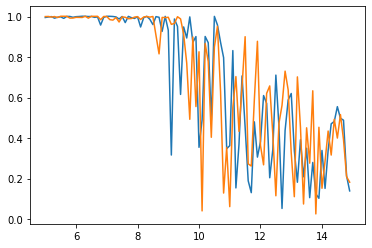

In [31]:

# = [numTasks,totalTime,meanInterarrivalTime,meanWaitTime,meanServiceTime,
#    cpuUtilization,maxQueueLength,meanQueueLength,stdQueueLength] 
"""
numTasks = results[0]
totalTime = results[1]
meanInterarrivalTime = results[2]
meanWaitTime = results[3]
meanServiceTime = results[4]
cpuUtilization = results[5]
maxQueueLength = results[6]
meanQueueLength = results[7]
stdQueueLength = results[8]
"""        


def plotStatistics3(numTasks,lams,beta):
    fRes = []
    sRes = []
    SJFStat = []     
    FIFOStat = []   
    
    for i in range(len(lams)):         
        fRes = analyzeResults(run(getTaskList(numTasks,lams[i],beta),"FIFO",False),False,False)         
        littles_ratio = ((fRes[7] + fRes[5]) / ((fRes[3] + fRes[4]) / fRes[2]))         
        FIFOStat.append(littles_ratio)         
        sRes = analyzeResults(run(getTaskList(numTasks,lams[i],beta),"SJF",False),False,False)         
        littles_ratio2 = ((sRes[7] + sRes[5]) / ((sRes[3] + sRes[4]) / sRes[2]))         
        SJFStat.append(littles_ratio2)     
    a = plt.plot(lams,FIFOStat)     
    b = plt.plot(lams,SJFStat)     
    plt.show()    
    # Your code here

# It took me an hour to run all the codes in this homework so I am not sure of how consistent they are.    
    
numTasks = 500
lams = list(np.arange(5,15,0.1))   # the different values of lam to use in this problem
beta = 0.1                         # mean service time of arriving tasks -- do not change this parameter
    
plotStatistics3(numTasks,lams,beta)